# Neural Network that works

In [1]:
import numpy as np
from zipfile import ZipFile
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import random
import torch.nn.functional as F
import argparse
from sklearn import metrics
from tqdm.notebook import tqdm
import gc
import shutil 
import mne
import pickle
import torch.utils.data as data_utils

In [2]:
labels = ['HandStart', 'FirstDigitTouch', 'BothStartLoadPhase', 'LiftOff',
       'Replace', 'BothReleased']
#chanelWant = ['Fp1', 'FC1', 'Fp2', 'P7', 'FC5', 'T7', 'F8', 'P4', 'CP5', 'P3', 'T8', 'Oz', 'FC6', 'O2', 'Cz', 'Fz', 'P8', 'C3', 'CP6', 'CP2', 'CP1', 'Pz', 'O1', 'F3', 'F7', 'C4', 'FC2', 'F4']

In [3]:
torch.manual_seed(2021)
np.random.seed(2021)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

parser = argparse.ArgumentParser()
parser.add_argument("--n_epochs", type=int, default=1, help="number of epochs of training")
# change batch sizes for both datasets
# seed 
parser.add_argument("--seedbatchsize",type=int, default = 1024,help='size of batches for the seed dataset')
parser.add_argument("--batch_size", type=int, default=1024, help="size of the batches")

parser.add_argument("--lr", type=float, default=0.002, help="adam's learning rate")
parser.add_argument("--b1", type=float, default=0.5, help="adam: decay of first order momentum of gradient")
parser.add_argument("--b2", type=float, default=0.99, help="adam: decay of first order momentum of gradient")
parser.add_argument("--n_cpu", type=int, default=1, help="number of cpu threads to use during batch generation")
parser.add_argument("--in_len", type=int, default=2**10, help="length of the input fed to neural net")
# changing the signal channels to take 28 input channels
# uncomment for 28
parser.add_argument("--in_channels", type=int, default=28, help="number of signal channels")
#parser.add_argument("--in_channels", type=int, default=22, help="number of signal channels")
# changing the signal channels to output 
parser.add_argument("--outMotion_channels", type=int, default=6, help="number of motion classes")
parser.add_argument("--outEmotion_channels", type=int, default=1, help="number of emotion classes")
parser.add_argument("--chunk", type=int, default=1000, help="length of splited chunks")
opt, unknown = parser.parse_known_args()
print(device)

cuda


In [4]:
# Reading the dataset
with open('trainset.pickle','rb') as f:
    trainset = pickle.load(f)
with open('labels.pickle','rb') as f:
    gt = pickle.load(f)
with open('Seeddata.pickle', 'rb') as f:
    SeedTrainset = pickle.load(f)
with open('Seedvaliddata.pickle', 'rb') as f:
    SeedValidset = pickle.load(f)

In [5]:
# train valid split
valid_dataset = trainset[-2:]
valid_gt = gt[-2:]
trainset = trainset[:-2]
gt = gt[:-2]

In [26]:
valid_dataset

[array([[-167., -183., -222., ...,  243.,  278.,  236.],
        [ 151.,  153.,  171., ...,  -93.,  -52.,  -58.],
        [ 188.,  190.,  181., ...,  -35.,  -42.,  -76.],
        ...,
        [ -23.,   16.,   19., ..., -465., -441., -479.],
        [ 108.,  112.,  131., ..., -403., -396., -419.],
        [ 421.,  427.,  427., ..., -177., -180., -221.]], dtype=float32),
 array([[-1581., -1556., -1540., ...,   211.,   192.,   191.],
        [  -83.,   -77.,  -112., ...,    16.,     5.,     0.],
        [-1790., -1781., -1874., ...,   276.,   263.,   210.],
        ...,
        [ -222.,  -202.,  -182., ...,   272.,   278.,   259.],
        [ -370.,  -372.,  -379., ...,  -111.,  -122.,  -126.],
        [ -256.,  -238.,  -238., ...,   129.,   131.,   189.]],
       dtype=float32)]

In [6]:
def resample_data(gt, chunk_size=opt.chunk):
    """
    split long signals to smaller chunks, discard no-events chunks  
    """
    total_discard_chunks = 0
    mean_val = []
    threshold = 0.01
    index = []
    
    for i in range(len(gt)):
        for j in range(0, gt[i].shape[1], chunk_size):
            mean_val.append(np.mean(gt[i][:, j:min(gt[i].shape[1],j+chunk_size)]))
            if mean_val[-1] < threshold:  # discard chunks with low events time
                total_discard_chunks += 1
            else:
                index.extend([(i, k) for k in range(j, min(gt[i].shape[1],j+chunk_size))])

    plt.plot([0, len(mean_val)], [threshold, threshold], color='r')
    plt.scatter(range(len(mean_val)), mean_val, s=1)
    plt.show()
    print('Total number of chunks discarded: {} chunks'.format(total_discard_chunks))
    print('{}% data'.format(total_discard_chunks/len(mean_val)))
    del mean_val
    gc.collect()
    return index

Need to check if the EEG signal DATAset works for SEED

In [7]:
opt.seedbatchsize

1024

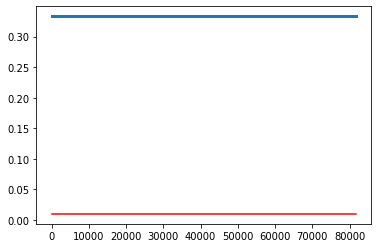

Total number of chunks discarded: 0 chunks
0.0% data


In [8]:

#the data loader for the SEED dataset


class EEGSEEDSignalDataset(Dataset):
    def __init__(self, data, soft_label=True, train=True):
        self.data = [el[1] for el in data]
        self.gt = [el[0] for el in data]
        self.train = train
        self.soft_label = soft_label
        self.eps = 1e-7
        # standardization steps
        if train:
            # we can remove eresampling as it is not required
            self.index = resample_data(self.gt)
        else:
            self.index = [(i, j) for i in range(len(data)) for j in range(data[i].shape[1])]
        for i,dt in enumerate(self.data):
            m = np.mean(dt,axis=0,keepdims=True)
            s = np.std(dt,axis=0,keepdims=True)
            dt = dt-m
            dt = dt/(s+self.eps)
            self.data[i] = dt
    
    def __getitem__(self, i):
        i,j = self.index[i]

        raw_data, label = self.data[i][:,max(0, j-opt.in_len+1):j+1],np.argwhere(self.gt[i][:,j]==1)[0] #\
        
#                 self.gt[i][:,j]
                  
#         print(label.shape)
        pad = opt.in_len - raw_data.shape[1]
        if pad:
            raw_data = np.pad(raw_data, ((0,0),(pad,0)), 'constant',constant_values=0)

        raw_data, label = torch.from_numpy(raw_data.astype(np.float32)),\
                            torch.from_numpy(label.astype(np.float32))
        if self.soft_label:
            label[label < .02] = .02
        return raw_data, label
            
    
    def __len__(self):
        return len(self.index) # need to alter this to show the length of each array within the list of arrays
    
seeddataset = EEGSEEDSignalDataset(SeedTrainset)
indices = torch.arange(4548000)
seed_10k = data_utils.Subset(seeddataset,indices)
# seeddataloader = DataLoader(seeddataset, batch_size = opt.seedbatchsize,\
#                 num_workers = opt.n_cpu, shuffle=True)
seeddataloader = DataLoader(seed_10k, batch_size = opt.seedbatchsize,\
                num_workers = opt.n_cpu, shuffle=True)

In [9]:
seeddataset[0]

(tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.7811],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  1.0212],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -1.9799],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -1.9175],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -1.8094],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.7914]]),
 tensor([2.]))

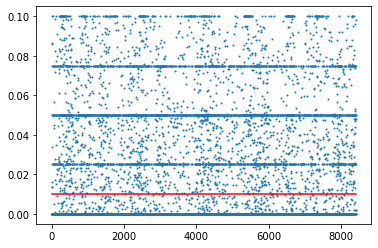

Total number of chunks discarded: 3865 chunks
0.45940805895637704% data
4548000


In [10]:
#%%time

#From IPython.core.debugger import set_trace()

class EEGSignalDataset(Dataset):
    def __init__(self, data, gt, soft_label=True, train=True):#b, seed = False):
        self.data = data
        self.gt = gt
        self.train = train
        self.soft_label = soft_label
        self.eps = 1e-7
        # standardization steps
        if train:
            self.index = resample_data(gt)
        else:
            self.index = [(i, j) for i in range(len(data)) for j in range(data[i].shape[1])]
        for i,dt in enumerate(self.data):
            m = np.mean(dt,axis=0,keepdims=True)
            s = np.std(dt,axis=0,keepdims=True)
            dt = dt-m
            dt = dt/(s+self.eps)
            self.data[i] = dt
    
    def __getitem__(self, i):
        i, j = self.index[i]

        raw_data, label = self.data[i][:,max(0, j-opt.in_len+1):j+1], \
                self.gt[i][:,j]
        
        pad = opt.in_len - raw_data.shape[1]
        if pad:
            raw_data = np.pad(raw_data, ((0,0),(pad,0)), 'constant',constant_values=0)

        raw_data, label = torch.from_numpy(raw_data.astype(np.float32)),\
                            torch.from_numpy(label.astype(np.float32))
        if self.soft_label:
            label[label < .02] = .02
        return raw_data, label
#        return {'raw_data': raw_data, 'ground_truth':label}   
    
    def __len__(self):
        return len(self.index)
try:    
    dataset = EEGSignalDataset(trainset, gt) 
    dataloader = DataLoader(dataset, batch_size = opt.batch_size,\
                                           num_workers = opt.n_cpu, shuffle=True)
    print(len(dataset))

except Exception:
    print(traceback.format_exc())
    # or
    print(sys.exc_info()[2])

Need to increase the batch sizes to meet the dataloader dimensions

In [11]:
print(len(seeddataset))
print(len(dataset))

81730640
4548000


In [12]:
print(len(seeddataloader))
print(len(dataloader))

4442
4442


# now the model begins

In [13]:
class MainNNet (nn.Module):
        def __init__(self, in_channels=opt.in_channels, out_channels=[opt.outEmotion_channels,opt.outMotion_channels]):
                super(MainNNet, self).__init__()
                self.hidden = 28
                self.net = nn.Sequential(
                        nn.Conv1d(opt.in_channels, opt.in_channels, 5, padding=2),
                        nn.ReLU(),
                        nn.Conv1d(self.hidden, self.hidden, 16, stride=16),
                        nn.LeakyReLU(0.1),
                        nn.Conv1d(self.hidden, self.hidden, 7, padding=3),
                        )
                self.emotion_predictor = nn.Sequential(
                        nn.MaxPool1d(2, 2),
                        nn.Dropout(p=0.1, inplace=True),
                        nn.Conv1d(in_channels, out_channels[0], 2, padding=2),
                        nn.LeakyReLU(0.1),
                        nn.Conv1d(out_channels[0], out_channels[0], 2, padding=2),
                        nn.AdaptiveMaxPool1d(1),
#                         nn.LeakyReLU(0.1),
                        )
                self.motion_predictor = nn.Sequential(
                        nn.MaxPool1d(2, 2),
                        nn.Dropout(p=0.1, inplace=True),
                        nn.Conv1d(in_channels, out_channels[1], 5, padding=2),
                        nn.LeakyReLU(0.1),
                        nn.Conv1d(out_channels[1], out_channels[1], 5, padding=2),
                        nn.AdaptiveMaxPool1d(1),
#                         nn.LeakyReLU(0.1),
                    
                        )

        def forward(self,x):
                nn_out = self.net(x)
                e_preds = self.emotion_predictor(nn_out)
                e_preds = e_preds.squeeze(-1).softmax(-1)
                m_preds = self.motion_predictor(nn_out)
                m_preds = m_preds.squeeze(-1).sigmoid()
                return {'emotion': e_preds, 'motion': m_preds}

In [21]:

from operator import xor

nnet = MainNNet()

nnet.to(device)
m_loss_fnc = nn.BCELoss()
e_loss_fnc = nn.CrossEntropyLoss()
adam = optim.Adam(nnet.parameters(), lr=opt.lr, betas=(opt.b1, opt.b2))
loss_his, train_loss = [], []
nnet.train()
stop = 0 # indicates that iterator is dry and should not swap anymore
flag = 0 # used to alternate training to optimize between the two objectives
alt_rate = 20 # alternate every 20 iterations
flag_map_str = {0: 'emotion', 1: 'motion'} # set up map to grab proper prediction based on flag

# push this into james training function
for epoch in range(opt.n_epochs):
        p_bar = tqdm(seeddataloader) # emotion
        s_bar = tqdm(dataloader) # motion

        stop = 0

        iter_p = iter(p_bar)
        iter_s = iter(s_bar)
        its = len(p_bar) + len(s_bar)

        for curr_it in range(its):
#                 print(curr_it)
                # make sure we are not swapping if iterator is at end for one (could also oversample to fix bias)
                if stop != 1:
                        # flip the flag every alt_rate
                        if curr_it % alt_rate == 0:
                                flag = xor(flag, 1)

                try:
                        (x , y) = next(iter_p) if flag==0 else next(iter_s)
#                         if isinstance(x,str):
#                             continue
                except:
                        stop=1
                        flag = xor(flag, 1)
                        curr_it=curr_it - 1
                        continue
                
#                 print(next(iter_p)[0].shape)
#                 print(y)
#                 print(x)
#                 print(next(iter_p)[1].shape)
                x, y = x.to(device), y.to(device)
                pred = nnet(x)
                if flag == 0:
                    
                    loss = e_loss_fnc(pred[flag_map_str[flag]], y)
                else:
                    loss = m_loss_fnc(pred[flag_map_str[flag]], y)
#                 lossMotion = loss_fnc(pred[flag_map_str[flag]], y)
#                 print('here after loss')
                adam.zero_grad()
#                 print('here after adam')
                loss.backward()
#                 print('here after backprop')
                adam.step()
#                 print('here after step')
                train_loss.append(loss.item())


  0%|          | 0/4442 [00:00<?, ?it/s]

  0%|          | 0/4442 [00:00<?, ?it/s]

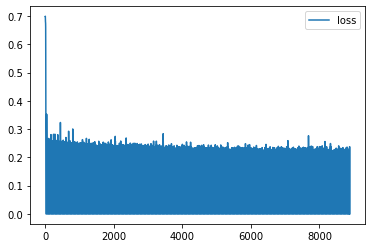

In [24]:
plt.plot(range(len(train_loss)), train_loss, label='loss')
plt.legend()
plt.show()

test on validation set

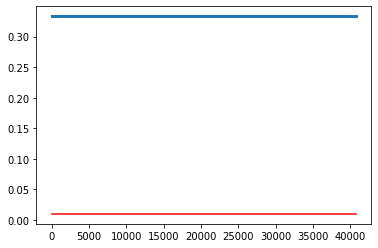

Total number of chunks discarded: 0 chunks
0.0% data


In [28]:
testset = EEGSignalDataset(valid_dataset, valid_gt, train=False, soft_label=False) 
testloader = DataLoader(testset, batch_size = opt.batch_size,\
                                       num_workers = opt.n_cpu, shuffle=False)

emotiontestset = EEGSEEDSignalDataset(SeedValidset,soft_label=False)
indices = torch.arange(6)
seedValid_2 = data_utils.Subset(emotiontestset,indices)
emotiontestloader = DataLoader(seedValid_2,batch_size = opt.batch_size,\
                               num_workers = opt.n_cpu, shuffle=False)



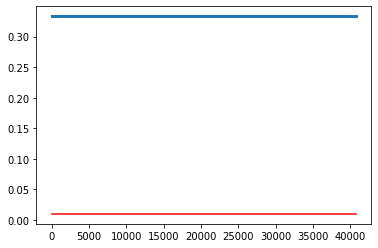

Total number of chunks discarded: 0 chunks
0.0% data


In [62]:
emotiontestset = EEGSEEDSignalDataset(SeedValidset,soft_label=False)
indices = torch.arange(2592924)
seedValid_2 = data_utils.Subset(emotiontestset,indices)
emotiontestloader = DataLoader(seedValid_2,batch_size = opt.batch_size,\
                               num_workers = opt.n_cpu, shuffle=False)

In [32]:
nnet.eval()
y_pred = []
ey_pred = []
with torch.no_grad():
#    m_iter = iter(testloader)
#    e_iter = iter(emotiontestloader)
    
    for x, _ in tqdm(testloader):
        x = x.to(device)
        pred = nnet(x)#.cpu().numpy()
        y_pred.append(pred['motion'])
        ey_pred.append(pred['emotion'])

  0%|          | 0/423 [00:00<?, ?it/s]

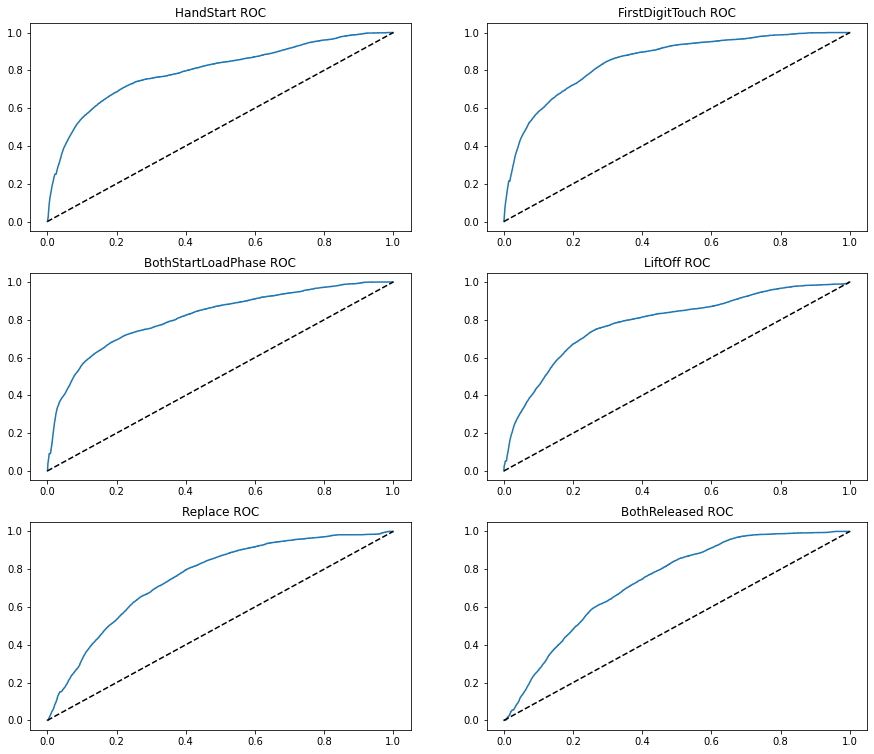

auc roc:  0.7908365392542814


In [39]:
def plot_roc(y_true, y_pred):
    fig, axs = plt.subplots(3, 2, figsize=(15,13))
    for i, label in enumerate(labels):
        fpr, tpr, _ = metrics.roc_curve(y_true[i], y_pred[i])
        ax = axs[i//2, i%2]
        ax.plot(fpr, tpr)
        ax.set_title(label+" ROC")
        ax.plot([0, 1], [0, 1], 'k--')

    plt.show()


y_pred_test = [i.detach().cpu().numpy() for i in y_pred]
y_pred_test = np.concatenate(y_pred_test, axis=0)#.squeeze(axis=-1)
valid_gt = np.concatenate(valid_gt, axis=1)
plot_roc(valid_gt, y_pred_test.T)
print('auc roc: ', metrics.roc_auc_score(valid_gt.T, y_pred_test))

ValueError: multiclass format is not supported

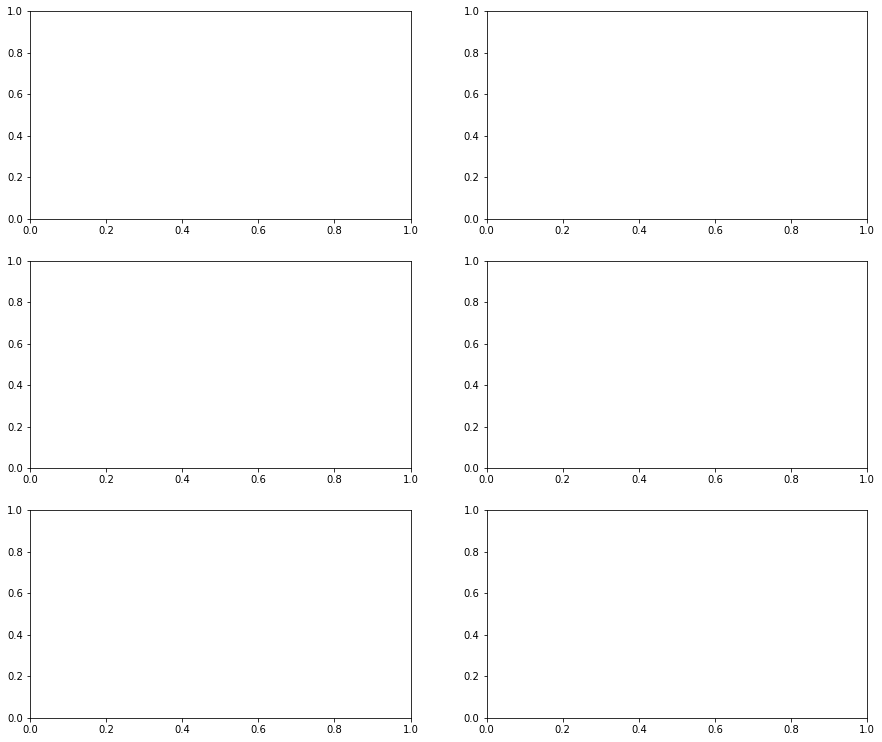

In [100]:
# emotionLabels = ['Fear','Neutral','Other']
# def plot_eroc(y_true, y_pred):
#     fig, axs = plt.subplots(3, 2, figsize=(15,13))
#     for i, label in enumerate(emotionLabels):
#         fpr, tpr, _ = metrics.roc_curve(y_true[i], y_pred[i])
#         ax = axs[i//2, i%2]
#         ax.plot(fpr, tpr)
#         ax.set_title(label+" ROC")
#         ax.plot([0, 1], [0, 1], 'k--')

#     plt.show()


ey_pred_test = [i.detach().cpu().numpy() for i in ey_pred]
ey_pred_test = np.concatenate(y_pred_test, axis=0)#.squeeze(axis=-1)
#valid_gt = np.concatenate(valid_gt, axis=1)
#plot_eroc(e_valid_gt, ey_pred_test.T)
#print('auc roc: ', metrics.eroc_auc_score(e_valid_gt.T, ey_pred_test))

In [78]:
# valid_labels =[]
# for i in seedValid_2:
#     valid_labels.append(i[1].cpu().numpy())
#seedValid_2[0][1]
e_valid_gt=[i[1].detach().cpu().numpy() for i in tqdm(seedValid_2)]

  0%|          | 0/2592924 [00:00<?, ?it/s]

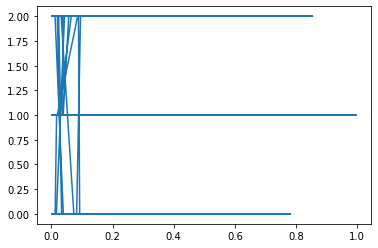

In [102]:
plt.plot(ey_pred_test,e_valid_gt.T)

In [106]:
valid_loss = e_valid_gt.T - ey_pred_test
plt.plot(range(len(ey_pred_test)), valid_loss, label='valid_loss')
plt.legend()
plt.show()

MemoryError: Unable to allocate 24.5 TiB for an array with shape (2592924, 2592924) and data type float32

In [95]:
#e_valid_gt = np.vstack(e_valid_gt)
e_valid_gt = e_valid_gt.T

In [66]:
len(y_pred_test)

432154

In [70]:
(valid_gt.shape)

(6, 432154)